#  NLP_ENDOPATHS_Nicolai

Author: Nicolai Wolpert  
Email: nicolai.wolpert@capgemini.com  
Date: June 2024

Script to test LSTM models to predict patient symptoms from gynéco text files

## Imports

In [1]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
import seaborn as sns
#import eli5 # eli5 not working anymore for current stable version of sklearn
from IPython.display import display

from preprocess_NLP import from_X_split_get_Y_split
from sklearn.utils import resample, shuffle

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import *
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Kfold cross-validation with stratification
from Opti_utils.ML_utils import kfold_cv_stratified, sensi, speci

# Custom preprocessing : 
from preprocess_NLP import preprocess_and_split

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

import pickle

[nltk_data] Downloading package stopwords to /home/nounou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-01-24 15:30:41.779903: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 15:30:42.007651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 15:30:50.082797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/numpy/core/getlimits.py:542:

In [2]:
model_dir = '../../models/'
pred_dir = '../../predictions/'

## Load data

In [3]:
# Loading X : 
df_nlp = pd.read_csv('./../../Data/Generate/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
print('X shape is :', df_nlp.shape)

# Loading Y : 
# Two options:
# 1) Take the original 'receuil' file as ground truth. In that case select 'receuil_orig'
# 2) Take the infos extracted manually from the gyneco file by a human observer as ground truth. In that case select 'gyneco_manual'
data_option = 'gyneco_manual'
if data_option=='receuil_orig':
    recueil  = pd.read_excel('./../../Data/Raw/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
    recueil.replace(['Na', 'NA'], np.nan, inplace=True)
    recueil.set_index('Numéro anonymat', inplace=True)
elif data_option=='gyneco_manual':
    recueil  = pd.read_excel('./../../Data/Generate/data_gynéco_manual_extraction.xlsx')
    recueil.set_index('Anonymisation', inplace=True)
print('Y shape is :', recueil.shape)
print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')

if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'
'NJ-055' in list(df_nlp['Anonymisation'])
'DJ-055' in list(df_nlp['Anonymisation'])

FileNotFoundError: [Errno 2] No such file or directory: './../../Data/Generate/donnees_entree_nlp_sans_endo.csv'

In [4]:
'''
# Les features qui ont été identifiés comme les plus pertinentes pour pouvoir prédire l'endiométrose profonde sont les suivants
# (cela veut dire qu'ils donnent une sensibilité et spécificité au dessus du seuil de 0.4 et 0.5):
features_of_interest = ['age', 'atcd.endo', 'sf.dsm.eva', 'sf.dpc', 'tv.douleur.lusd', 'tv.douleur.lusg', 'chir_GD', 'chir_SW']
'''
# See 'Explore_features_ML_NLP' for how these have been identified
features_of_interest = ['atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']
features_of_interest = ['irm.lusg']
#features_of_interest = 'all'

In [5]:
if features_of_interest != 'all':
    recueil = recueil[features_of_interest]

In [6]:
percent_missing = recueil.isnull().sum() * 100 / recueil.shape[0]
missing_value_df = pd.DataFrame({'column_name': recueil.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
irm.lusg,irm.lusg,53.977273


### LSTM

In [7]:
use_validation_set = True
train_proportion = 0.7

#### LSTM for one feature

In [13]:
target_feature = 'irm.lusg'
_, _, _, _, max_vocab, X, Y = preprocess_and_split( df_nlp,
                                                   recueil,
                                                   target_feature,
                                                   42,                     # choix de la seed pour le random split
                                                   0.20,                   # Choix du test_size
                                                   special_char=True,      # supprime les caractères spéciaux  
                                                   accents=False,          # supprime les accents
                                                   lower=True,            # passe la casse du texte en minuscule
                                                   token=False,            # tokenize le corpus
                                                   remove_stopwords=True,
                                                   drop_number=True,
                                                   compress=True,          # un corpus par n_ano, shape = [200,2]
                                                   preprocess_mode='multiclass',
                                                   encoder_mode=True,
                                                   anapath=True,
                                                   correction_by_json=True
                                                   )
Y = Y[[target_feature]]
nclasses = len(np.unique(Y.values.flatten()))
if nclasses==2:
    Y_one_hot = to_categorical(Y, num_classes=2)
    Y_one_hot = pd.DataFrame(Y_one_hot, columns=['négatif', 'positif'], index=Y.index)
else:
    Y_one_hot = to_categorical(Y, num_classes=3)
    Y_one_hot = pd.DataFrame(Y_one_hot, columns=['négatif', 'positif', 'valeur_manquante'], index=Y.index)

# Split :
X_train, X_test = train_test_split(X, random_state=42, test_size=0.2)
indeces_test = list(X_test.index)
Y_train = from_X_split_get_Y_split(X_train, Y_one_hot)
Y_test = from_X_split_get_Y_split(X_test, Y_one_hot).values

if use_validation_set:
    X_val = X_train.iloc[X_train.shape[0]-10:,:]
    indeces_val = list(X_val.index)
    Y_val = Y_train.iloc[Y_train.shape[0]-10:,:].values
    X_train = X_train.iloc[:X_train.shape[0]-10,:]
    indeces_train = list(X_train.index)
    Y_train = Y_train.iloc[:Y_train.shape[0]-10,:].values
print(f'Number of training samples: {X_train.shape[0]}')
if use_validation_set: print(f'Number of validation samples: {X_val.shape[0]}');
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'Number of classes: {nclasses}')

Number of training samples: 114
Number of validation samples: 10
Number of testing samples: 31
Number of classes: 3


In [14]:
max_vocab_size = max_vocab 

tokenizer = Tokenizer(num_words=max_vocab_size, split=' ', oov_token='<unw>', filters=' ')
if use_validation_set:
    tokenizer.fit_on_texts(pd.concat([X_train,X_val]).loc[:,'Résumé'])
else:
    tokenizer.fit_on_texts(X_train['Résumé'])

# This encodes our sentence as a sequence of integer
# each integer being the index of each word in the vocabulary
train_seqs = tokenizer.texts_to_sequences(X_train.loc[:,'Résumé'])
if use_validation_set: valid_seqs = tokenizer.texts_to_sequences(X_val.loc[:,'Résumé']);
test_seqs = tokenizer.texts_to_sequences(X_test.loc[:,'Résumé'])

# We need to pad the sequences so that they are all the same length :
# the length of the longest one
max_seq_length = max( [len(seq) for seq in train_seqs + valid_seqs] )

X_train_pad = pad_sequences(train_seqs, max_seq_length)
X_valid_pad = pad_sequences(valid_seqs, max_seq_length)
X_test_pad = pad_sequences(test_seqs, max_seq_length)

embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2

def get_lstm_model(vocab_size, embedding_dim, lstm_out_dim, dropout_rate, n_dense, nclasses):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))

    model.add(LSTM(units=lstm_out_dim, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=lstm_out_dim))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))

    if nclasses==2:
        print('2 classes, using binary crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='sigmoid'))
        model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    else:
        print(f'{nclasses} classes, using categorical crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    
    return model

model = get_lstm_model(max_vocab_size, embedding_dim, lstm_out_dim, dropout_rate, n_dense=Y_train.shape[1], nclasses=nclasses)
# print(model.summary())
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
batch_size = 64
max_epochs = 10

'''
if use_validation_set:
    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, verbose=1, validation_data = (X_valid_pad, Y_val), callbacks=[early_stopping])
else:
    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
'''

3 classes, using categorical crossentropy


'\nif use_validation_set:\n    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, verbose=1, validation_data = (X_valid_pad, Y_val), callbacks=[early_stopping])\nelse:\n    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])\n'

In [15]:
predictions = model.predict(X_test_pad)
predictions

KeyboardInterrupt: 

In [11]:
predictions_df = pd.DataFrame(columns=[target_feature + '_predicted', target_feature + '_real'])
#predictions_df[target_feature + '_predicted_proba'] = predictions
predictions_df[target_feature + '_predicted'] = np.argmax(predictions, axis=1).tolist()
predictions_df[target_feature + '_real'] = np.argmax(Y_test, axis=1).tolist()
predictions_df.head()

,irm.lusg_predicted,irm.lusg_real
0,0,1
1,1,1
2,2,2
3,0,2
4,0,2


In [12]:
print(classification_report(predictions_df[target_feature + '_real'], predictions_df[target_feature + '_predicted']))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         4
           1       0.12      0.11      0.12         9
           2       0.47      0.39      0.42        18

    accuracy                           0.32        31
   macro avg       0.28      0.33      0.29        31
weighted avg       0.34      0.32      0.32        31



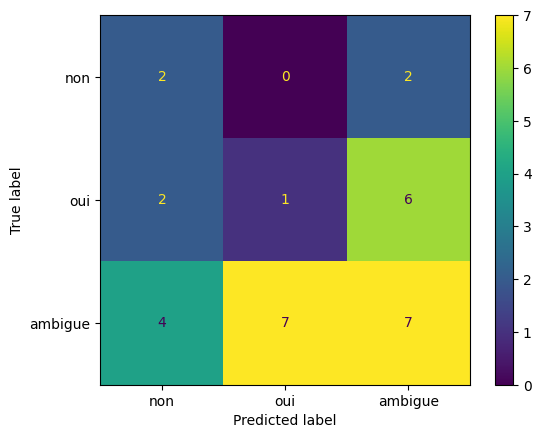

In [13]:
cm = confusion_matrix(predictions_df[target_feature + '_real'], predictions_df[target_feature + '_predicted'])
if len(pd.unique(recueil[target_feature]))==2:
    labels=['non', 'oui']
else:
    labels=['non', 'oui', 'ambigue']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

#### Upsampling to account for class imbalances

In [ ]:
target_feature = 'irm.lusg'
preprocess_mode = 'multiclass'      # 'multiclass' = garder les nan et les traiter comme classe, 'dropnan' = enlever les nan
_, _, _, _, max_vocab, X, Y = preprocess_and_split( df_nlp,
                                                   recueil,
                                                   target_feature,
                                                   42,                     # choix de la seed pour le random split
                                                   0.20,                   # Choix du test_size
                                                   special_char=True,      # supprime les caractères spéciaux  
                                                   accents=False,          # supprime les accents
                                                   lower=True,            # passe la casse du texte en minuscule
                                                   token=False,            # tokenize le corpus
                                                   remove_stopwords=True,
                                                   drop_number=True,
                                                   compress=True,          # un corpus par n_ano, shape = [200,2]
                                                   preprocess_mode=preprocess_mode,
                                                   encoder_mode=True,
                                                   anapath=True,
                                                   correction_by_json=True
                                                   )
Y = Y[[target_feature]]
nclasses = len(np.unique(Y.values.flatten()))
if nclasses==2:
    Y_one_hot = to_categorical(Y, num_classes=2)
    Y_one_hot = pd.DataFrame(Y_one_hot, columns=['négatif', 'positif'], index=Y.index)
else:
    Y_one_hot = to_categorical(Y, num_classes=3)
    Y_one_hot = pd.DataFrame(Y_one_hot, columns=['négatif', 'positif', 'valeur_manquante'], index=Y.index)

# Split :
X_train, X_test = train_test_split(X, random_state=42, test_size=0.2)
indeces_test = list(X_test.index)
Y_train = from_X_split_get_Y_split(X_train, Y_one_hot)
Y_test = from_X_split_get_Y_split(X_test, Y_one_hot).values

if use_validation_set:
    X_val = X_train.iloc[X_train.shape[0]-10:,:]
    indeces_val = list(X_val.index)
    Y_val = Y_train.iloc[Y_train.shape[0]-10:,:].values
    X_train = X_train.iloc[:X_train.shape[0]-10,:]
    indeces_train = list(X_train.index)
    Y_train = Y_train.iloc[:Y_train.shape[0]-10,:].values
print(f'Number of samples in total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}')
print(f'Number of training samples: {X_train.shape[0]}')
if use_validation_set: print(f'Number of validation samples: {X_val.shape[0]}');
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'Number of classes: {nclasses}')

Number of samples in total: 155
Number of training samples: 114
Number of validation samples: 10
Number of testing samples: 31
Number of classes: 3


In [11]:
data = pd.merge(X, Y_one_hot.reset_index().rename(columns={'Numéro anonymat': 'Anonymisation'}), on='Anonymisation')
data = pd.merge(data, Y.reset_index().rename(columns={'Numéro anonymat': 'Anonymisation'}), on='Anonymisation')
data.head()

,Anonymisation,Résumé,négatif,positif,valeur_manquante,atcd.endo
0,SL-041,minidril pilule sans arrêt entre plaquettes sa...,1.0,0.0,0.0,0.0
1,NJ-001,rien va depuis intervention a appelé ici sem t...,0.0,0.0,1.0,2.0
2,NA-185,pvpp paracétamol toutes heures si douleurs boi...,0.0,0.0,1.0,2.0
3,DC-122,niveau digestif douleurs avant pendant exonéra...,0.0,1.0,0.0,1.0
4,SL-077,appel jour post opus persistance douleurs post...,0.0,1.0,0.0,1.0


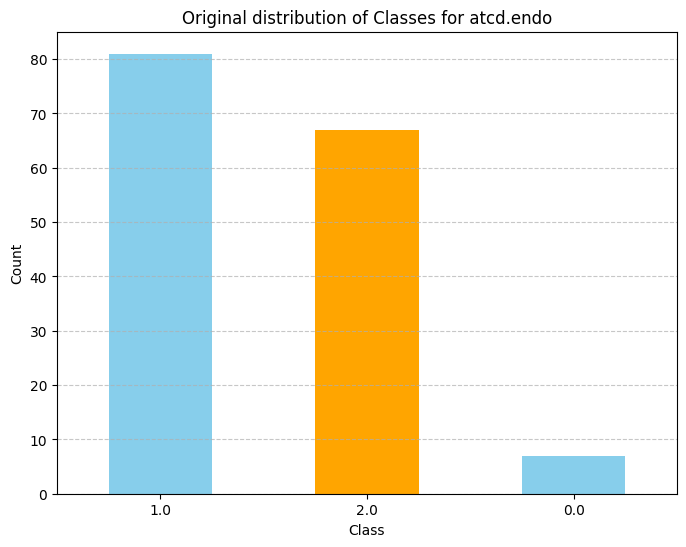

In [12]:
# Calculate the distribution of classes for the selected feature
class_counts = data[target_feature].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title(f'Original distribution of Classes for {target_feature}')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [13]:
data_negative = data.loc[data[target_feature]==0.0]
data_positive = data.loc[data[target_feature]==1.0]
data_missing = data.loc[data[target_feature]==2.0]

if len(data_negative) > len(data_positive):
    data_majority = data_negative
    data_minority = data_positive
else:
    data_majority = data_positive
    data_minority = data_negative

bias = data_minority.shape[0]/data_majority.shape[0]

# split train/test data first 
data_train = pd.concat([data_majority.sample(frac=train_proportion,random_state=200),
         data_minority.sample(frac=train_proportion,random_state=200), data_missing.sample(frac=train_proportion,random_state=200)])
data_test = pd.concat([data_majority.drop(data_majority.sample(frac=train_proportion,random_state=200).index),
        data_minority.drop(data_minority.sample(frac=train_proportion,random_state=200).index), data_missing.drop(data_missing.sample(frac=train_proportion,random_state=200).index)])


data_test_negative = data_test.loc[data_test[target_feature]==0.0]
data_test_positive = data_test.loc[data_test[target_feature]==1.0]
data_test_missing = data_test.loc[data_test[target_feature]==2.0]
if use_validation_set:
    data_val = pd.concat([data_test_negative.sample(frac=0.5,random_state=200),
            data_test_positive.sample(frac=0.5,random_state=200), data_test_missing.sample(frac=0.5,random_state=200)])
    data_test = pd.concat([data_test_negative.drop(data_test_negative.sample(frac=0.5,random_state=200).index),
            data_test_positive.drop(data_test_positive.sample(frac=0.5,random_state=200).index), data_test_missing.drop(data_test_missing.sample(frac=0.5,random_state=200).index)])

data_train = shuffle(data_train)
if use_validation_set: data_val = shuffle(data_val)
data_test = shuffle(data_test)

In [14]:
data_positive_train = (data_train[target_feature] == 1.0).sum()
data_negative_train = (data_train[target_feature] == 0.0).sum()
data_ambiguous_train = (data_train[target_feature] == 2.0).sum()
print('positive data in training:', data_positive_train)
print('negative data in training:', data_negative_train)
print('ambiguous data in training:', data_ambiguous_train)
print()
if use_validation_set:
    print('positive data in validation:',(data_val[target_feature] == 1.0).sum())
    print('negative data in validation:',(data_val[target_feature] == 0.0).sum())
    print('ambiguous data in validation:',(data_val[target_feature] == 2.0).sum())
    print()
print('positive data in test:',(data_test[target_feature] == 1.0).sum())
print('negative data in test:',(data_test[target_feature] == 0.0).sum())
print('ambiguous data in test:',(data_test[target_feature] == 2.0).sum())

positive data in training: 57
negative data in training: 5
ambiguous data in training: 47

positive data in validation: 12
negative data in validation: 1
ambiguous data in validation: 10

positive data in test: 12
negative data in test: 1
ambiguous data in test: 10


In [15]:
# Separate majority and minority classes in training data for upsampling
if nclasses==2:
    if len(data_train[data_train[target_feature] == 0.0]) > len(data_train[data_train[target_feature] == 1.0]):
        data_train_majority = data_train[data_train[target_feature] == 0.0]
        data_train_minority = data_train[data_train[target_feature] == 1.0]
    else:
        data_train_majority = data_train[data_train[target_feature] == 1.0]
        data_train_minority = data_train[data_train[target_feature] == 0.0]

    print("majority class before upsample:",data_train_majority.shape)
    print("minority class before upsample:",data_train_minority.shape)

    # Upsample minority class
    data_train_minority_upsampled = resample(data_train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples= data_train_majority.shape[0],    # to match majority class
                                    random_state=123) # reproducible results
    
    # Combine majority class with upsampled minority class
    data_train_upsampled = pd.concat([data_train_majority, data_train_minority_upsampled])
    
elif nclasses==3:
    if data_positive_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = data_train[data_train[target_feature] == 1.0]
        data_train_minority1 = data_train[data_train[target_feature] == 0.0]
        data_train_minority2 = data_train[data_train[target_feature] == 2.0]
    elif data_negative_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = data_train[data_train[target_feature] == 0.0]
        data_train_minority1 = data_train[data_train[target_feature] == 1.0]
        data_train_minority2 = data_train[data_train[target_feature] == 2.0]
    elif data_ambiguous_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = data_train[data_train[target_feature] == 2.0]
        data_train_minority1 = data_train[data_train[target_feature] == 0.0]
        data_train_minority2 = data_train[data_train[target_feature] == 1.0]

    print("majority class before upsample:",data_train_majority.shape)
    print("minority class 1 before upsample:",data_train_minority1.shape)
    print("minority class 2 before upsample:",data_train_minority2.shape)

    # Upsample minority class 1
    data_train_minority1_upsampled = resample(data_train_minority1, 
                                    replace=True,     # sample with replacement
                                    n_samples= data_train_majority.shape[0],    # to match majority class
                                    random_state=123) # reproducible results
    # Upsample minority class 2
    data_train_minority2_upsampled = resample(data_train_minority2, 
                                    replace=True,     # sample with replacement
                                    n_samples= data_train_majority.shape[0],    # to match majority class
                                    random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    data_train_upsampled = pd.concat([data_train_majority, data_train_minority1_upsampled, data_train_minority2_upsampled])

# Display new class counts
print("After upsampling\n",data_train_upsampled[target_feature].value_counts(),sep = "")

majority class before upsample: (57, 6)
minority class 1 before upsample: (5, 6)
minority class 2 before upsample: (47, 6)
After upsampling
atcd.endo
1.0    57
0.0    57
2.0    57
Name: count, dtype: int64


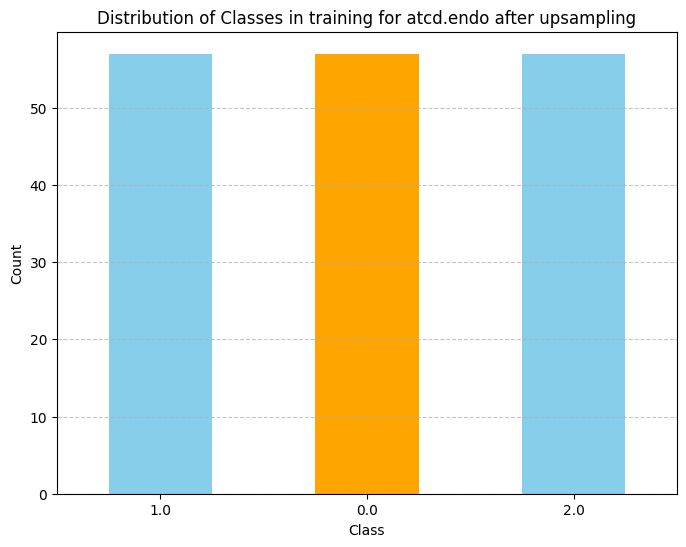

In [16]:
# Calculate the distribution of classes for the selected feature
class_counts = data_train_upsampled[target_feature].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title(f'Distribution of Classes in training for {target_feature} after upsampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [17]:
if nclasses==2:
    X_train = data_train_upsampled[['Anonymisation', 'Résumé']]
    Y_train = data_train_upsampled[['négatif', 'positif']].values
    if use_validation_set:
        X_val = data_val[['Anonymisation', 'Résumé']]
        Y_val = data_val[['négatif', 'positif']].values
    X_test = data_test[['Anonymisation', 'Résumé']]
    Y_test = data_test[['négatif', 'positif']].values
else:
    X_train = data_train_upsampled[['Anonymisation', 'Résumé']]
    Y_train = data_train_upsampled[['négatif', 'positif', 'valeur_manquante']].values
    if use_validation_set:
        X_val = data_val[['Anonymisation', 'Résumé']]
        Y_val = data_val[['négatif', 'positif', 'valeur_manquante']].values
    X_test = data_test[['Anonymisation', 'Résumé']]
    Y_test = data_test[['négatif', 'positif', 'valeur_manquante']].values

print(f'Number of training samples: {X_train.shape[0]}')
if use_validation_set: print(f'Number of validation samples: {X_val.shape[0]}');
print(f'Number of testing samples: {X_test.shape[0]}')

Number of training samples: 171
Number of validation samples: 23
Number of testing samples: 23


In [19]:
max_vocab_size = max_vocab 

tokenizer = Tokenizer(num_words=max_vocab_size, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(pd.concat([X_train,X_val]).loc[:,'Résumé'])

# This encodes our sentence as a sequence of integer
# each integer being the index of each word in the vocabulary
train_seqs = tokenizer.texts_to_sequences(X_train.loc[:,'Résumé'])
if use_validation_set: valid_seqs = tokenizer.texts_to_sequences(X_val.loc[:,'Résumé']);
test_seqs = tokenizer.texts_to_sequences(X_test.loc[:,'Résumé'])

# We need to pad the sequences so that they are all the same length :
# the length of the longest one
max_seq_length = max( [len(seq) for seq in train_seqs + valid_seqs] )

X_train_pad = pad_sequences(train_seqs, max_seq_length)
if use_validation_set: X_valid_pad = pad_sequences(valid_seqs, max_seq_length);
X_test_pad = pad_sequences(test_seqs, max_seq_length)

embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2

def get_lstm_model(vocab_size, embedding_dim, lstm_out_dim, dropout_rate, n_dense, nclasses):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True))

    model.add(LSTM(units=lstm_out_dim, return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_out_dim))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))

    if nclasses==2:
        print('2 classes, using binary crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='sigmoid'))
        model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    else:
        print(f'{nclasses} classes, using categorical crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    
    return model


model = get_lstm_model(max_vocab_size, embedding_dim, lstm_out_dim, dropout_rate, n_dense=Y_train.shape[1], nclasses=nclasses)
# print(model.summary())
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
batch_size = 64
max_epochs = 20
if use_validation_set:
    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, 
                        verbose=1, validation_data = (X_valid_pad, Y_val), callbacks=[early_stopping])
else:
    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1)
pickle.dump(model, open(model_dir + f'lstm_upsampled_{preprocess_mode}_{target_feature}'.replace('.', '_'), 'wb'))

3 classes, using categorical crossentropy
Epoch 1/20
3/3 [==============================] - 2921s 909s/step - loss: 1.0973 - accuracy: 0.4094 - recall: 0.0000e+00 - val_loss: 1.0995 - val_accuracy: 0.3043 - val_recall: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 4205s 1220s/step - loss: 1.0854 - accuracy: 0.6199 - recall: 0.0000e+00 - val_loss: 1.0888 - val_accuracy: 0.3478 - val_recall: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 4973s 1626s/step - loss: 1.0289 - accuracy: 0.6199 - recall: 0.0000e+00 - val_loss: 1.1321 - val_accuracy: 0.2174 - val_recall: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 4853s 1453s/step - loss: 0.8324 - accuracy: 0.6608 - recall: 0.2982 - val_loss: 1.0142 - val_accuracy: 0.4348 - val_recall: 0.4348
Epoch 5/20
3/3 [==============================] - 3802s 1136s/step - loss: 0.7438 - accuracy: 0.6023 - recall: 0.5322 - val_loss: 1.0007 - val_accuracy: 0.3913 - val_recall: 0.0870
Epoch 6/20
3/3 [==============

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         434100    
                                                                 
 lstm (LSTM)                 (None, None, 200)         240800    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [33]:
#model = pickle.load(open(model_dir + f'lstm_upsampled_{preprocess_mode}_{target_feature}'.replace('.', '_'), 'rb'))

In [21]:
predictions = model.predict(X_test_pad)
predictions

1/1 [==============================] - 6s 6s/step


array([[1.52393207e-02, 9.12291110e-01, 7.24695399e-02],
       [5.06269792e-03, 6.92942739e-01, 3.01994592e-01],
       [6.71300441e-02, 8.96421850e-01, 3.64481360e-02],
       [1.62296109e-02, 9.16204214e-01, 6.75661638e-02],
       [3.55532800e-04, 1.20279916e-01, 8.79364491e-01],
       [2.57306790e-04, 1.14774607e-01, 8.84968102e-01],
       [3.17806174e-04, 1.11283503e-01, 8.88398707e-01],
       [1.29172523e-02, 8.36346567e-01, 1.50736153e-01],
       [7.94465945e-04, 2.26165593e-01, 7.73039937e-01],
       [1.08072618e-02, 9.14616644e-01, 7.45760351e-02],
       [6.29264722e-03, 7.37667620e-01, 2.56039709e-01],
       [7.96606112e-03, 8.50004554e-01, 1.42029434e-01],
       [6.05453271e-03, 7.95313895e-01, 1.98631644e-01],
       [6.41240776e-02, 8.85504484e-01, 5.03713489e-02],
       [6.01970172e-03, 7.11875439e-01, 2.82104820e-01],
       [8.11534375e-03, 8.28343511e-01, 1.63541183e-01],
       [1.27034253e-02, 8.51419926e-01, 1.35876656e-01],
       [1.25777535e-03, 2.86652

In [22]:
predictions_df = pd.DataFrame(columns=[target_feature + '_real', target_feature + '_predicted', target_feature + '_confidence'])
#predictions_df[target_feature + '_predicted_proba'] = predictions
predictions_df[target_feature + '_real'] = np.argmax(Y_test, axis=1).tolist()
predictions_df[target_feature + '_predicted'] = np.argmax(predictions[:, :2], axis=1).tolist()      # Ignorer la catégorie "données manquantes"
predictions_df[target_feature + '_confidence'] = np.max(predictions[:, :2], axis=1).tolist()
predictions_df.to_csv(pred_dir + f'predictions_lstm_upsampled_{preprocess_mode}_{target_feature}'.replace('.', '_') + '.csv')
predictions_df.head()

,atcd.endo_real,atcd.endo_predicted,atcd.endo_confidence
0,1,1,0.912291
1,1,1,0.692943
2,1,1,0.896422
3,2,1,0.916204
4,0,1,0.120280


In [23]:
print(classification_report(predictions_df[target_feature + '_real'], predictions_df[target_feature + '_predicted']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.52      1.00      0.69        12
           2       0.00      0.00      0.00        10

    accuracy                           0.52        23
   macro avg       0.17      0.33      0.23        23
weighted avg       0.27      0.52      0.36        23



c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

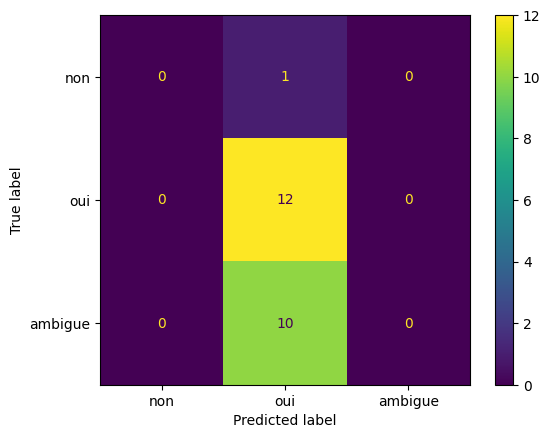

In [24]:
cm = confusion_matrix(predictions_df[target_feature + '_real'], predictions_df[target_feature + '_predicted'])
if len(pd.unique(recueil[target_feature]))==2:
    labels=['non', 'oui']
else:
    labels=['non', 'oui', 'ambigue']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

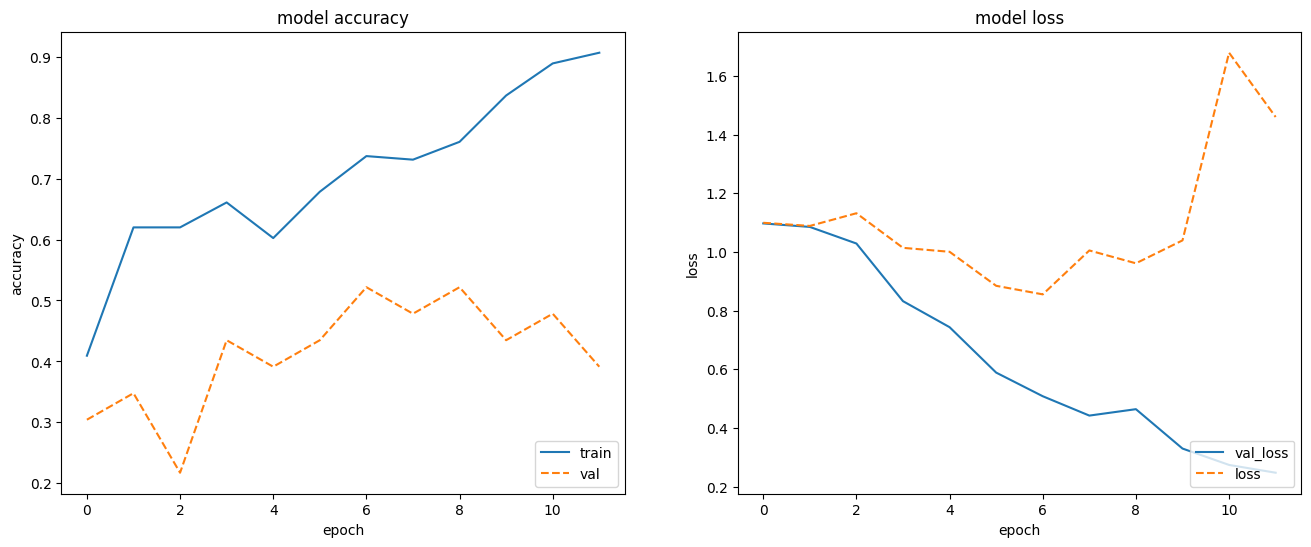

In [25]:
if use_validation_set:
    fig, axes = plt.subplots(1, 2, figsize = (16,6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'],'--')
    axes[0].set_title('model accuracy')
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'val'], loc='lower right')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'],"--")
    axes[1].set_title('model loss')
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Thresholding approach

In [37]:
liste_resultats = []
for threshold in np.arange(0.05, 1, 0.01):
    dict_ = {}
    predicted_values = [1 if pred_proba > threshold else 0 for pred_proba in predictions[:, 1]]
    true_values = np.argmax(Y_test, axis=1).tolist()
    # Remove missing data
    predicted_values = [x for i, x in enumerate(predicted_values) if true_values[i] != 2]
    true_values = [x for x in true_values if x != 2]
    sensib = sensi(true_values, predicted_values)
    specic = speci(true_values, predicted_values)
    dict_['trhd']=threshold
    dict_['sensi']=sensib
    dict_['speci']=specic
    liste_resultats.append(dict_)
resultats = pd.DataFrame(liste_resultats)

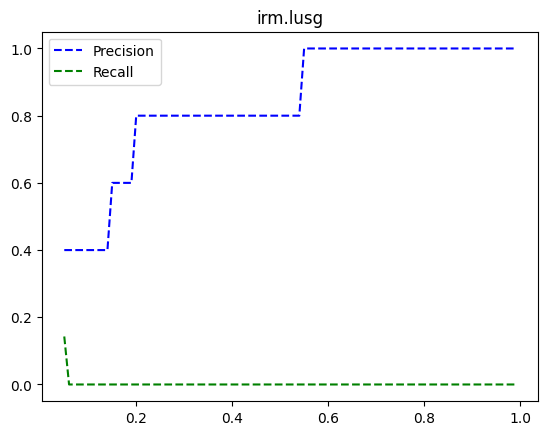

In [38]:
plt.figure()
plt.plot(resultats.trhd, resultats.speci, '--', color='blue')
plt.plot(resultats.trhd, resultats.sensi, '--', color='green')
plt.legend(['Precision', 'Recall'])
plt.title(f'{target_feature}')
plt.show()

#### LSTM for all features

In [5]:
X_train, X_test, Y_train, Y_test, max_vocab, X, Y = preprocess_and_split( df_nlp,
                                                                    recueil,
                                                                    features_of_interest,
                                                                    42,                     # choix de la seed pour le random split
                                                                    0.20,                   # Choix du test_size
                                                                    special_char=True,      # supprime les caractères spéciaux  
                                                                    accents=False,          # supprime les accents
                                                                    lower=True,            # passe la casse du texte en minuscule
                                                                    token=False,            # tokenize le corpus
                                                                    remove_stopwords=True,
                                                                    drop_number=True,
                                                                    compress=True,          # un corpus par n_ano, shape = [200,2]
                                                                    preprocess_mode='multiclass',
                                                                    encoder_mode=True,
                                                                    anapath=True,
                                                                    correction_by_json=True
                                                                  )
X_val = X_train.iloc[X_train.shape[0]-10:,:]
Y_val = Y_train.iloc[Y_train.shape[0]-10:,:]
X_train = X_train.iloc[:X_train.shape[0]-10,:]
Y_train = Y_train.iloc[:Y_train.shape[0]-10,:]
nclasses = len(np.unique(Y.values.flatten()))
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'Number of classes: {nclasses}')


Nothing to one-hot encode
Number of training samples: 115
Number of validation samples: 10
Number of testing samples: 32
Number of classes: 3


In [6]:
X_train.head()

,Anonymisation,Résumé
136,SN-028,paracetamol toutes si douleurs contramal compr...
55,RA-119,utrogestan capsule per os voie vaginale jour d...
124,EH-032,androcur comprimé jour tous jours sans interru...
84,SM-138,doxycycline matin soir jusqu'au inclus metroni...
105,KS-016,prise charge douleur post opératoire ixprim co...


In [7]:
Y_train.head()

,atcd.endo,irm.lusg,tv.douloureux,irm.externe,sf.dig.diarrhee,echo.lusg,echo.lusd,ef.hormone.dpc,effet.hormone
Numéro anonymat,,,,,,,,,
SN-028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
RA-119,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
EH-032,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,0.0
SM-138,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
KS-016,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [8]:
max_vocab_size = max_vocab 

tokenizer = Tokenizer(num_words=max_vocab_size, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(pd.concat([X_train,X_val]).loc[:,'Résumé'])

# This encodes our sentence as a sequence of integer
# each integer being the index of each word in the vocabulary
train_seqs = tokenizer.texts_to_sequences(X_train.loc[:,'Résumé'])
valid_seqs = tokenizer.texts_to_sequences(X_val.loc[:,'Résumé'])
test_seqs = tokenizer.texts_to_sequences(X_test.loc[:,'Résumé'])

In [9]:
# We need to pad the sequences so that they are all the same length :
# the length of the longest one
max_seq_length = max( [len(seq) for seq in train_seqs + valid_seqs] )

X_train_pad = pad_sequences(train_seqs, max_seq_length)
X_valid_pad = pad_sequences(valid_seqs, max_seq_length)
X_test_pad = pad_sequences(test_seqs, max_seq_length)

embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2
nclasses = len(np.unique(Y_train.values.flatten()))

def get_lstm_model(vocab_size, embedding_dim, seq_length, lstm_out_dim, dropout_rate, n_dense, nclasses):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length))

    '''
    model.add(LSTM(units=lstm_out_dim, return_sequences=True))
    model.add(Dropout(dropout_rate))
    '''

    model.add(LSTM(units=lstm_out_dim))
    model.add(Dropout(dropout_rate))

    '''
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))
    '''

    if nclasses==2:
        print('2 classes, using binary crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='sigmoid'))
        model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    else:
        print(f'{nclasses} classes, using categorical crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    return model


model = get_lstm_model(max_vocab_size, embedding_dim, max_seq_length, lstm_out_dim, dropout_rate, n_dense=Y_train.shape[1], nclasses=nclasses)
# print(model.summary())
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
batch_size = 64
max_epochs = 10
history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=0, validation_data = (X_valid_pad, Y_val), callbacks=[early_stopping])

c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3 classes, using categorical crossentropy


KeyboardInterrupt: 

In [ ]:
predictions = model.predict(X_test_pad)
predictions_df = pd.DataFrame(predictions, columns=Y_test.columns, index=Y_test.index)
predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


,atcd.endo,irm.lusg,tv.douloureux,irm.externe,sf.dig.diarrhee,echo.lusg,echo.lusd,ef.hormone.dpc,effet.hormone
Numéro anonymat,,,,,,,,,
OA-031,0.148385,0.210039,0.128922,0.306069,0.062941,0.003495,0.000503,0.000186,0.139462
AE-060,0.149167,0.208053,0.128527,0.308147,0.063437,0.003511,0.000503,0.000186,0.138470
VC-088,0.148964,0.209275,0.128843,0.306494,0.062928,0.003520,0.000506,0.000187,0.139283
TJ-090,0.147875,0.207908,0.130282,0.307096,0.063355,0.003493,0.000505,0.000187,0.139298
BN-128,0.148771,0.208883,0.128807,0.307599,0.062890,0.003501,0.000504,0.000186,0.138859
MJ-173,0.148443,0.208441,0.129354,0.306721,0.062900,0.003492,0.000506,0.000188,0.139955
NN-075,0.149180,0.207406,0.130470,0.306542,0.063931,0.003507,0.000506,0.000185,0.138274
TV-050,0.148167,0.210282,0.129293,0.305425,0.063639,0.003519,0.000510,0.000189,0.138976
EH-032,0.147968,0.207816,0.129921,0.307484,0.063437,0.003497,0.000507,0.000188,0.139183


In [38]:
Y_test

,atcd.endo,irm.lusg,tv.douloureux,irm.externe,sf.dig.diarrhee,echo.lusg,echo.lusd,ef.hormone.dpc,effet.hormone
Numéro anonymat,,,,,,,,,
GM-113,0,1,1,0,0,1,1,0,0
JJ-002,0,0,1,0,0,0,0,1,1
OG-035,1,1,1,0,0,1,0,0,1
CC-166,0,1,0,0,1,1,1,0,1
CO-110,0,1,1,0,0,0,0,0,1
EM-049,1,0,1,1,0,0,0,0,1
VA-139,1,1,1,1,0,0,0,0,0
HB-158,0,0,0,0,1,1,0,0,0
FE-135,0,0,0,1,0,0,0,0,1


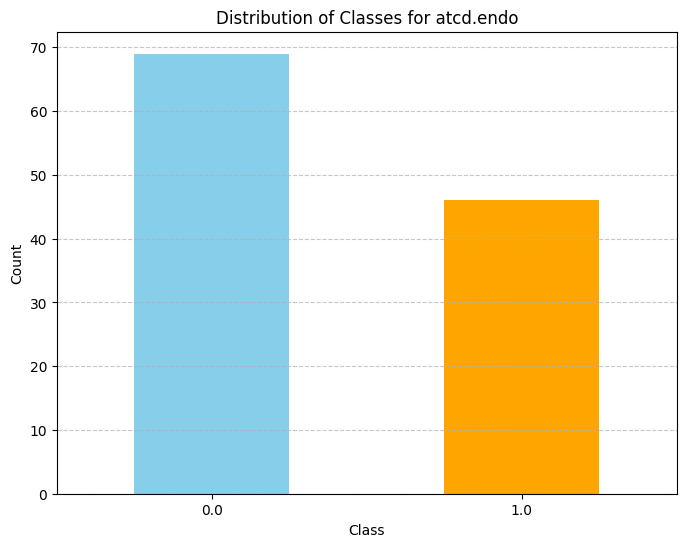

In [49]:
# Select the feature to visualize
feature = 'atcd.endo'

# Calculate the distribution of classes for the selected feature
class_counts = Y_train[feature].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title(f'Distribution of Classes for {feature}')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

## Show results across features

In [8]:
upsampling = True
preprocess_mode = 'multiclass'

results_per_feat = pd.DataFrame(columns=['feature', 'precision_0', 'recall_0', 'f1_score_0', 'precision_1', 'recall_1', 'f1_score_1'])
for feature in features_of_interest:
    feature_read = feature.replace('.', '_')
    if upsampling:
        predictions_df = pd.read_csv(pred_dir + f'predictions_lstm_upsampled_{preprocess_mode}_{feature_read}.csv')
    else:
        predictions_df = pd.read_csv(pred_dir + f'predictions_lstm_{preprocess_mode}_{feature_read}.csv')

    classif_report = classification_report(predictions_df[feature + '_real'], predictions_df[feature + '_predicted'], output_dict=True)

    results_per_feat = pd.concat([results_per_feat, pd.DataFrame({'feature': [feature], 
                                                                'precision_0': [classif_report['0']['precision']], 'recall_0': [classif_report['0']['recall']], 'f1_score_0': [classif_report['0']['f1-score']],
                                                                'precision_1': [classif_report['1']['precision']], 'recall_1': [classif_report['1']['recall']], 'f1_score_1': [classif_report['1']['f1-score']]})])
    
results_per_feat = pd.concat({'metrics': results_per_feat.set_index('feature').transpose()})
results_per_feat

C:\Users\nwolpert\AppData\Local\Temp\ipykernel_24964\3944984713.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_per_feat = pd.concat([results_per_feat, pd.DataFrame({'feature': [feature],
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precis

feature              atcd.endo  irm.lusg  tv.douloureux  irm.externe  \
metrics precision_0   0.705882  0.769231       0.384615     0.200000   
        recall_0      0.923077  0.666667       0.555556     0.066667   
        f1_score_0    0.800000  0.714286       0.454545     0.100000   
        precision_1   0.833333  0.500000       0.500000     0.263158   
        recall_1      0.500000  0.625000       0.454545     0.555556   
        f1_score_1    0.625000  0.555556       0.476190     0.357143   

feature              sf.dig.diarrhee  echo.lusg  echo.lusd  ef.hormone.dpc  \
metrics precision_0         0.562500   0.555556   0.578947        0.578947   
        recall_0            0.692308   0.769231   0.733333        0.846154   
        f1_score_0          0.620690   0.645161   0.647059        0.687500   
        precision_1         0.428571   0.200000   0.000000        0.500000   
        recall_1            0.333333   0.142857   0.000000        0.400000   
        f1_score_1          0.375000   0.166667   0.000000        0.444444   

feature              effet.hormone  
metrics precision_0         0.2800  
        recall_0            1.0000  
        f1_score_0          0.4375  
        precision_1         0.0000  
        recall_1            0.0000  
        f1_score_1          0.0000

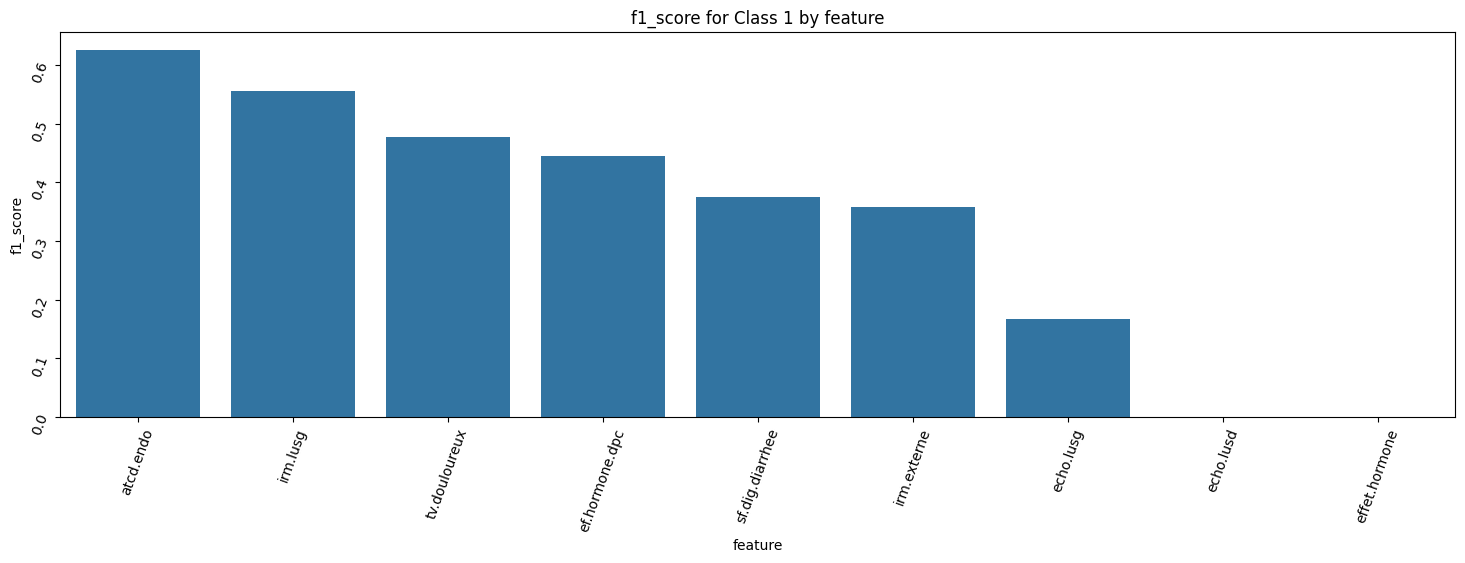

In [9]:
show_best_and_lowest_scores(results_per_feat, score='f1_score')

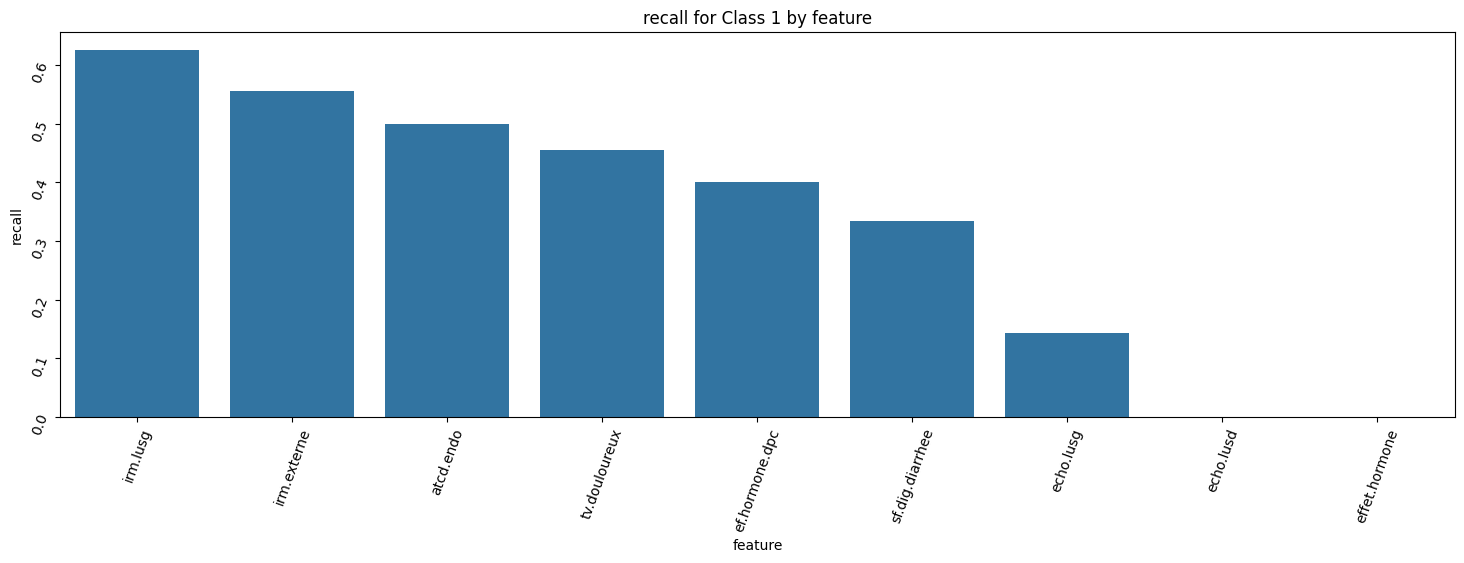

In [10]:
show_best_and_lowest_scores(results_per_feat, score='recall')

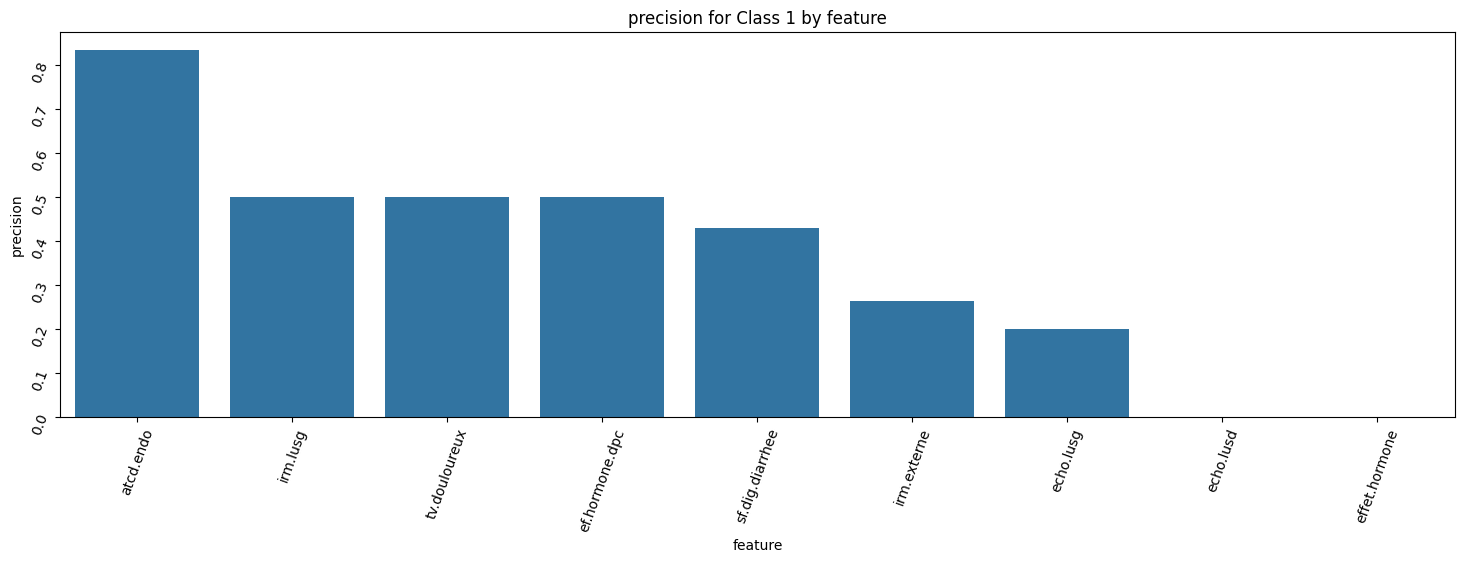

In [11]:
show_best_and_lowest_scores(results_per_feat, score='precision')

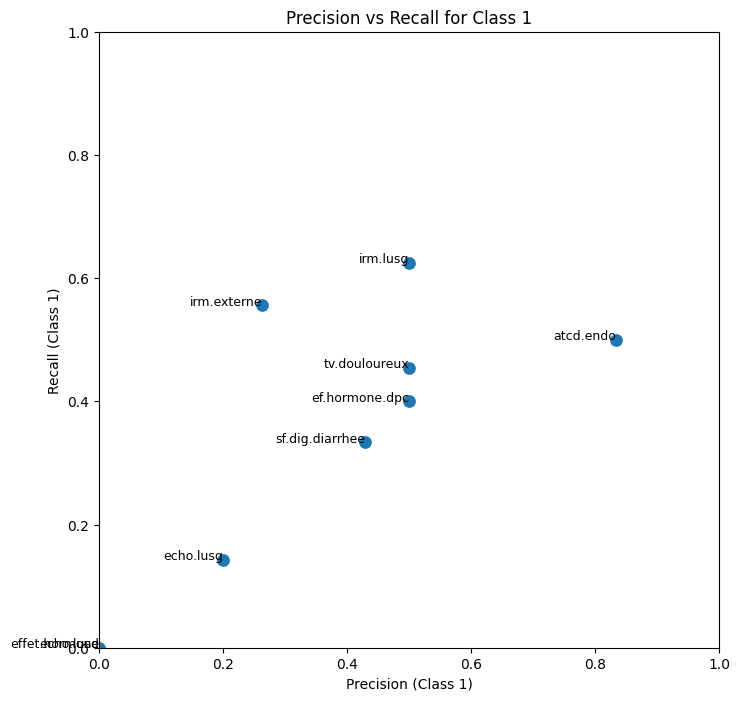

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Precision vs Recall for Class 1'}, xlabel='Precision (Class 1)', ylabel='Recall (Class 1)'>)

In [9]:
show_precision_vs_recall(results_per_feat)

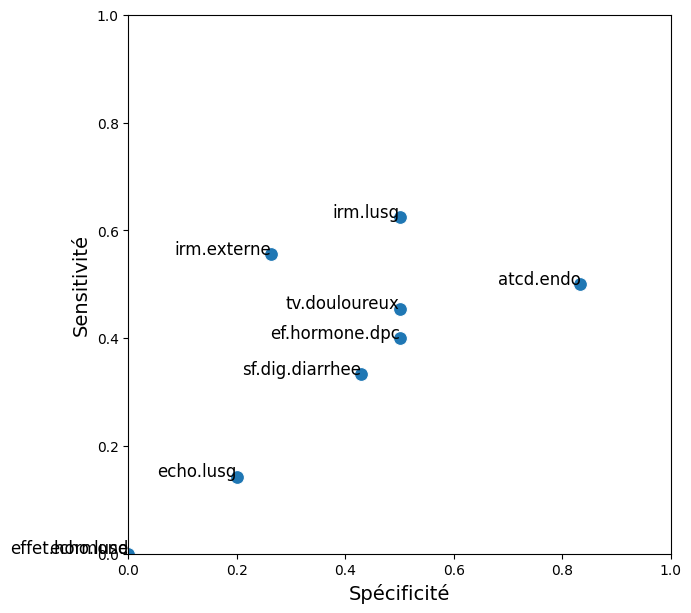

In [13]:
### Nicer plot for presentations
features_of_interest=None
normalize_scale=True

# Extract precision_1 and recall_1
df_plot = results_per_feat.loc['metrics'].copy()
precision_1 = df_plot.loc['precision_1']
recall_1 = df_plot.loc['recall_1']

# Filter out NaN values
valid_indices = precision_1.notna() & recall_1.notna()
precision_1 = precision_1[valid_indices]
recall_1 = recall_1[valid_indices]

fig, ax = plt.subplots(figsize=(7, 7))
if features_of_interest != None:
    sns.scatterplot(x=precision_1, y=recall_1, hue=precision_1.index.isin(features_of_interest), palette={True: 'red', False: 'blue'}, s=100, edgecolor='w')
else:
    sns.scatterplot(x=precision_1, y=recall_1, s=100, edgecolor='w')

# Ajouter des labels pour chaque point
for feature in precision_1.index:
    plt.text(precision_1[feature], recall_1[feature], feature, fontsize=12, ha='right')

if normalize_scale:
    plt.xlim([0, 1])
    plt.ylim([0, 1])
plt.xlabel('Spécificité', fontsize=14)
plt.ylabel('Sensitivité', fontsize=14)
plt.title('', fontsize=15)
if features_of_interest != None:
    handles, labels = ax.get_legend_handles_labels()
    labels = ['Other Features', 'Best features for endo. prediction']
    plt.legend(handles=handles, labels=labels, loc='best')
plt.show()

### Compare performance dropping vs. keeping nans

In [40]:
upsampling = True
preprocess_mode = 'multiclass'

results_per_feat_keepna = pd.DataFrame(columns=['feature', 'precision_0', 'recall_0', 'f1_score_0', 'precision_1', 'recall_1', 'f1_score_1'])
for feature in features_of_interest:
    feature_read = feature.replace('.', '_')
    if upsampling:
        predictions_df = pd.read_csv(pred_dir + f'predictions_lstm_upsampled_{preprocess_mode}_{feature_read}.csv')
    else:
        predictions_df = pd.read_csv(pred_dir + f'predictions_lstm_{preprocess_mode}_{feature_read}.csv')

    classif_report = classification_report(predictions_df[feature + '_real'], predictions_df[feature + '_predicted'], output_dict=True)

    results_per_feat_keepna = pd.concat([results_per_feat_keepna, pd.DataFrame({'feature': [feature], 
                                                                'precision_0': [classif_report['0']['precision']], 'recall_0': [classif_report['0']['recall']], 'f1_score_0': [classif_report['0']['f1-score']],
                                                                'precision_1': [classif_report['1']['precision']], 'recall_1': [classif_report['1']['recall']], 'f1_score_1': [classif_report['1']['f1-score']]})])
    
results_per_feat_keepna = pd.concat({'metrics': results_per_feat_keepna.set_index('feature').transpose()})
results_per_feat_keepna

C:\Users\nwolpert\AppData\Local\Temp\ipykernel_17520\4234736169.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_per_feat_keepna = pd.concat([results_per_feat_keepna, pd.DataFrame({'feature': [feature],
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMe

feature              atcd.endo  irm.lusg  tv.douloureux  irm.externe  \
metrics precision_0   0.555556  0.733333       0.333333     0.625000   
        recall_0      0.769231  0.733333       0.111111     0.666667   
        f1_score_0    0.645161  0.733333       0.166667     0.645161   
        precision_1   0.400000  0.500000       0.500000     0.375000   
        recall_1      0.200000  0.500000       0.909091     0.333333   
        f1_score_1    0.266667  0.500000       0.645161     0.352941   

feature              sf.dig.diarrhee  echo.lusg  echo.lusd  ef.hormone.dpc  \
metrics precision_0         0.285714   0.625000   0.625000        0.590909   
        recall_0            0.153846   0.769231   0.666667        1.000000   
        f1_score_0          0.200000   0.689655   0.645161        0.742857   
        precision_1         0.312500   0.428571   0.142857        0.000000   
        recall_1            0.555556   0.428571   0.200000        0.000000   
        f1_score_1          0.400000   0.428571   0.166667        0.000000   

feature              effet.hormone  
metrics precision_0       0.300000  
        recall_0          0.428571  
        f1_score_0        0.352941  
        precision_1       0.533333  
        recall_1          0.615385  
        f1_score_1        0.571429

In [41]:
upsampling = True
preprocess_mode = 'dropna'

results_per_feat_dropna = pd.DataFrame(columns=['feature', 'precision_0', 'recall_0', 'f1_0', 'precision_1', 'recall_1', 'f1_1'])
for feature in features_of_interest:
    feature_read = feature.replace('.', '_')
    if upsampling:
        predictions_df = pd.read_csv(pred_dir + f'predictions_lstm_upsampled_{preprocess_mode}_{feature_read}.csv')
    else:
        predictions_df = pd.read_csv(pred_dir + f'predictions_lstm_{preprocess_mode}_{feature_read}.csv')

    classif_report = classification_report(predictions_df[feature + '_real'], predictions_df[feature + '_predicted'], output_dict=True)

    results_per_feat_dropna = pd.concat([results_per_feat_dropna, pd.DataFrame({'feature': [feature], 
                                                                'precision_0': [classif_report['0']['precision']], 'recall_0': [classif_report['0']['recall']], 'f1_score_0': [classif_report['0']['f1-score']],
                                                                'precision_1': [classif_report['1']['precision']], 'recall_1': [classif_report['1']['recall']], 'f1_score_1': [classif_report['1']['f1-score']]})])
    
results_per_feat_dropna = pd.concat({'metrics': results_per_feat_dropna.set_index('feature').transpose()})
results_per_feat_dropna

C:\Users\nwolpert\AppData\Local\Temp\ipykernel_17520\880558842.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_per_feat_dropna = pd.concat([results_per_feat_dropna, pd.DataFrame({'feature': [feature],


feature             atcd.endo  irm.lusg tv.douloureux irm.externe  \
metrics precision_0  0.769231  0.578947           0.5         0.5   
        recall_0     0.769231  0.733333      0.111111    0.066667   
        f1_0              NaN       NaN           NaN         NaN   
        precision_1       0.7       0.0      0.555556    0.363636   
        recall_1          0.7       0.0      0.909091    0.888889   
        f1_1              NaN       NaN           NaN         NaN   
        f1_score_0   0.769231  0.647059      0.181818    0.117647   
        f1_score_1        0.7       0.0      0.689655    0.516129   

feature             sf.dig.diarrhee echo.lusg echo.lusd ef.hormone.dpc  \
metrics precision_0             0.5  0.647059  0.722222       0.764706   
        recall_0           0.538462  0.846154  0.866667            1.0   
        f1_0                    NaN       NaN       NaN            NaN   
        precision_1            0.25  0.333333       0.0            1.0   
        recall_1           0.222222  0.142857       0.0            0.2   
        f1_1                    NaN       NaN       NaN            NaN   
        f1_score_0         0.518519  0.733333  0.787879       0.866667   
        f1_score_1         0.235294       0.2       0.0       0.333333   

feature             effet.hormone  
metrics precision_0           0.6  
        recall_0         0.857143  
        f1_0                  NaN  
        precision_1           0.9  
        recall_1         0.692308  
        f1_1                  NaN  
        f1_score_0       0.705882  
        f1_score_1       0.782609

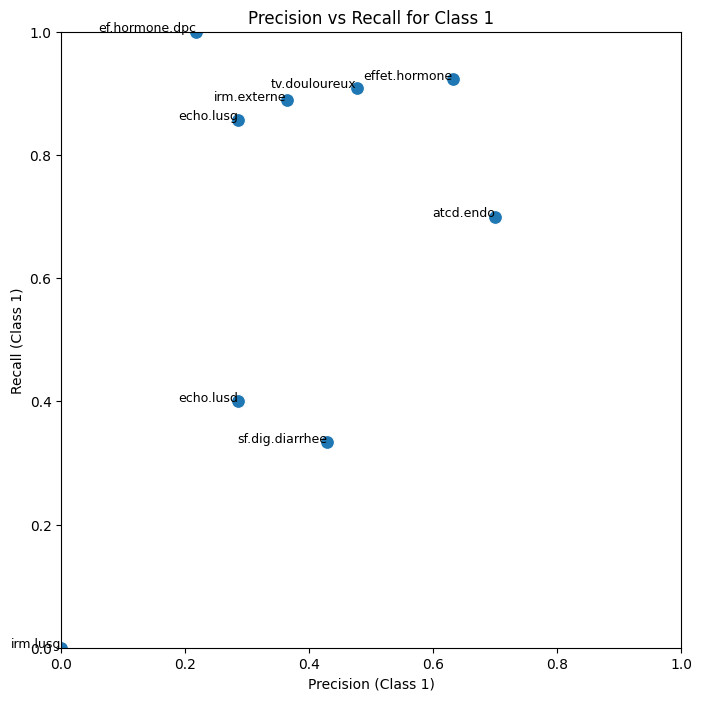

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Precision vs Recall for Class 1'}, xlabel='Precision (Class 1)', ylabel='Recall (Class 1)'>)

In [112]:
show_precision_vs_recall(results_per_feat_keepna)

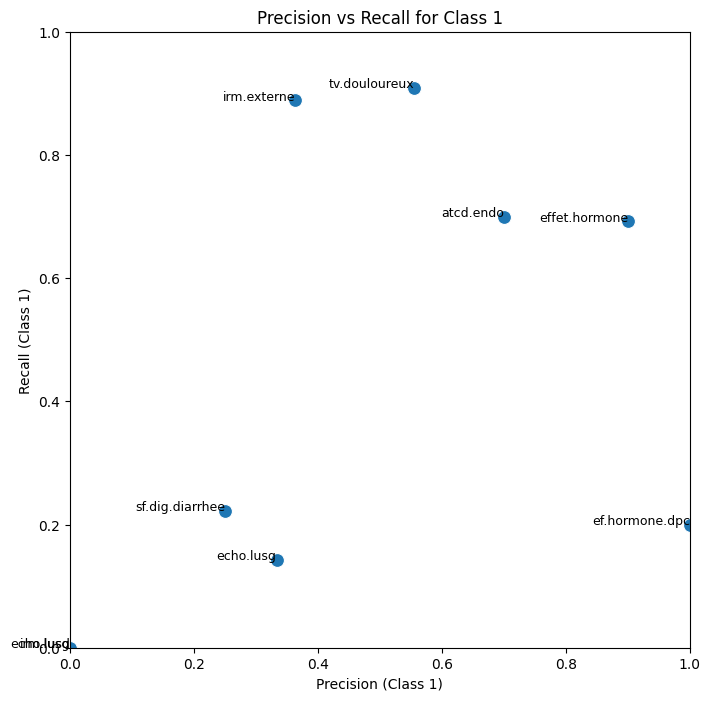

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Precision vs Recall for Class 1'}, xlabel='Precision (Class 1)', ylabel='Recall (Class 1)'>)

In [42]:
show_precision_vs_recall(results_per_feat_dropna)

### 2-step procedure: 1) Predict absence or presence of info in gyneco file 2) For those where info present, predict whether symptom absent or present

### 1) Info present or not

In [56]:
target_feature = 'atcd.endo'

In [57]:
# For this take the data where infos have been extracted manually from gyneco files
recueil  = pd.read_excel('./../../Data/Generate/data_gynéco_manual_extraction.xlsx')
recueil.set_index('Anonymisation', inplace=True)
recueil[target_feature] = recueil[target_feature].replace({np.nan: 2.0, 'NaN': 2.0})

Number of patients with info missing: 0
Number of patients with symptom present: 93
Number of patients with symptom absent: 8


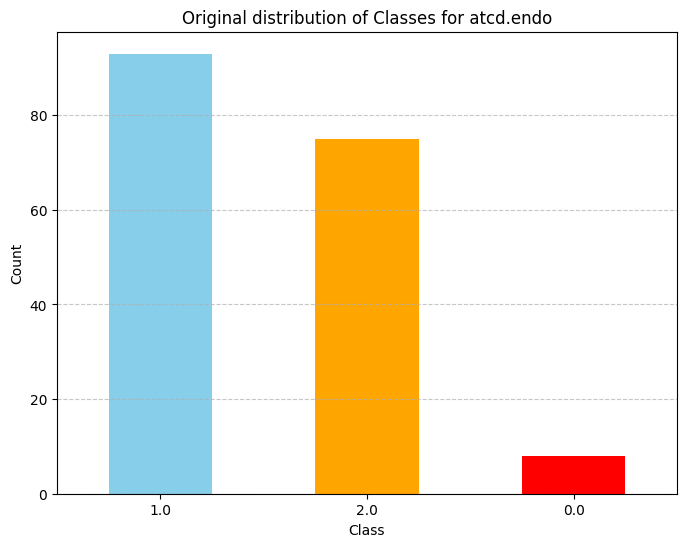

In [58]:
# Calculate the distribution of classes for the selected feature
class_counts = recueil[target_feature].value_counts()

nmissing = recueil[target_feature].isnull().sum()
npresent = recueil.loc[recueil[target_feature]==1].shape[0]
nabsent = recueil.loc[recueil[target_feature]==0].shape[0]
print(f'Number of patients with info missing: {nmissing}')
print(f'Number of patients with symptom present: {npresent}')
print(f'Number of patients with symptom absent: {nabsent}')

# Create a bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange', 'red'])
plt.title(f'Original distribution of Classes for {target_feature}')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [59]:
recueil_feature_present = recueil[[target_feature]].copy()
recueil_feature_present[target_feature] = recueil_feature_present[target_feature].replace({2.0: 0, 0.0: 1, 1.0: 1})
_, _, _, _, max_vocab, X, Y = preprocess_and_split( df_nlp,
                                                   recueil_feature_present,
                                                   'all',
                                                   42,                     # choix de la seed pour le random split
                                                   0.20,                   # Choix du test_size
                                                   special_char=True,      # supprime les caractères spéciaux  
                                                   accents=False,          # supprime les accents
                                                   lower=True,            # passe la casse du texte en minuscule
                                                   token=False,            # tokenize le corpus
                                                   remove_stopwords=True,
                                                   drop_number=True,
                                                   compress=True,          # un corpus par n_ano, shape = [200,2]
                                                   preprocess_mode='multiclass',
                                                   encoder_mode=True,
                                                   anapath=True,
                                                   correction_by_json=True
                                                   )

Y = Y[[target_feature]]

Y_one_hot = to_categorical(Y, num_classes=2)
Y_one_hot = pd.DataFrame(Y_one_hot, columns=['négatif', 'positif'], index=Y.index)

# Split :
X_train, X_test = train_test_split(X, random_state=42, test_size=0.2)
indeces_test = list(X_test.index)
Y_train = from_X_split_get_Y_split(X_train, Y_one_hot)
Y_test = from_X_split_get_Y_split(X_test, Y_one_hot).values

if use_validation_set:
    X_val = X_train.iloc[X_train.shape[0]-10:,:]
    indeces_val = list(X_val.index)
    Y_val = Y_train.iloc[Y_train.shape[0]-10:,:].values
    X_train = X_train.iloc[:X_train.shape[0]-10,:]
    indeces_train = list(X_train.index)
    Y_train = Y_train.iloc[:Y_train.shape[0]-10,:].values
print(f'Number of training samples: {X_train.shape[0]}')
if use_validation_set: print(f'Number of validation samples: {X_val.shape[0]}');
print(f'Number of testing samples: {X_test.shape[0]}')

Number of training samples: 114
Number of validation samples: 10
Number of testing samples: 31


In [60]:
data = pd.merge(X, Y_one_hot.reset_index().rename(columns={'Numéro anonymat': 'Anonymisation'}), on='Anonymisation')
data = pd.merge(data, Y.reset_index().rename(columns={'Numéro anonymat': 'Anonymisation'}), on='Anonymisation')
data_mentioned = data.loc[data[target_feature]==1.0]
data_not_mentioned = data.loc[data[target_feature]==0.0]

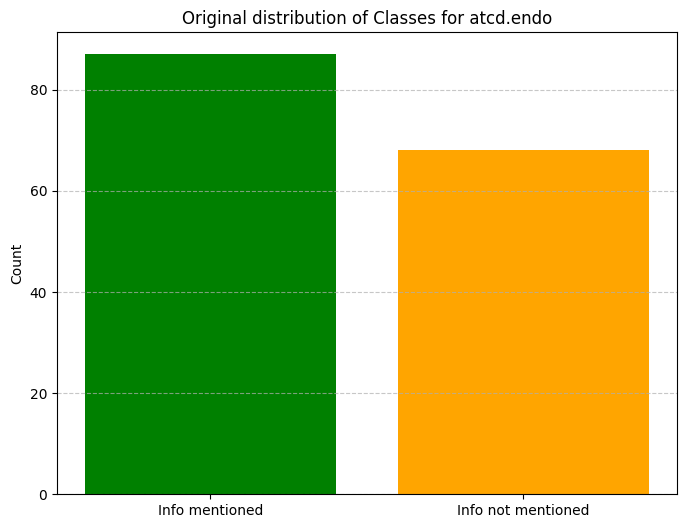

In [61]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar([1, 2], [data_mentioned.shape[0], data_not_mentioned.shape[0]], color=['green', 'orange'])
plt.title(f'Original distribution of Classes for {target_feature}')
plt.ylabel('Count')
plt.xticks([1, 2])
ax.set_xticklabels(['Info mentioned', 'Info not mentioned'])
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [62]:
if len(data_not_mentioned) > len(data_mentioned):
    data_majority = data_not_mentioned
    data_minority = data_mentioned
else:
    data_majority = data_mentioned
    data_minority = data_not_mentioned

bias = data_minority.shape[0]/data_majority.shape[0]

# split train/test data first 
data_train = pd.concat([data_majority.sample(frac=train_proportion,random_state=200), data_minority.sample(frac=train_proportion,random_state=200)])
data_test = pd.concat([data_majority.drop(data_majority.sample(frac=train_proportion,random_state=200).index), data_minority.drop(data_minority.sample(frac=train_proportion,random_state=200).index)])

data_mentioned_test = data_test.loc[data_test[target_feature] == 1.0]
data_not_mentioned_test = data_test.loc[data_test[target_feature] == 0.0]
if use_validation_set:
    data_val = pd.concat([data_not_mentioned_test.sample(frac=0.5,random_state=200),
            data_mentioned_test.sample(frac=0.5,random_state=200)])
    data_test = pd.concat([data_not_mentioned_test.drop(data_not_mentioned_test.sample(frac=0.5,random_state=200).index),
            data_mentioned_test.drop(data_mentioned_test.sample(frac=0.5,random_state=200).index)])

data_train = shuffle(data_train)
if use_validation_set: data_val = shuffle(data_val)
data_test = shuffle(data_test)

In [63]:
print('data with info present in training:',(data_train[target_feature] == 1.0).sum())
print('data with info missing in training:',(data_train[target_feature] == 0.0).sum())
if use_validation_set:
    print('data with info present in validation:',(data_val[target_feature] == 1.0).sum())
    print('data with info missing in validation:',(data_val[target_feature] == 0.0).sum())
print('data with info present in test:',(data_test[target_feature] == 1.0).sum())
print('data with info missing in test:',(data_test[target_feature] == 0.0).sum())

data with info present in training: 61
data with info missing in training: 48
data with info present in validation: 13
data with info missing in validation: 10
data with info present in test: 13
data with info missing in test: 10


In [64]:
# Separate majority and minority classes in training data for upsampling 
if len(data_train[data_train[target_feature] < 2]) > len(data_train[data_train[target_feature] == 2.0]):
    data_train_majority = data_train[data_train[target_feature] == 1.0]
    data_train_minority = data_train[data_train[target_feature] == 0.0]
else:
    data_train_majority = data_train[data_train[target_feature] == 1.0]
    data_train_minority = data_train[data_train[target_feature] == 0.0]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_train_minority_upsampled = resample(data_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_train_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data_train_upsampled = pd.concat([data_train_majority, data_train_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",data_train_upsampled[target_feature].value_counts(),sep = "")

majority class before upsample: (87, 5)
minority class before upsample: (68, 5)
After upsampling
atcd.endo
1.0    61
0.0    61
Name: count, dtype: int64


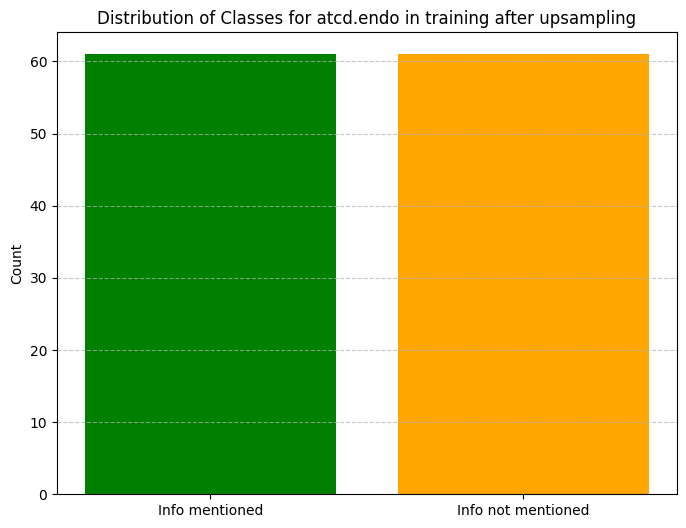

In [65]:
# Calculate the distribution of classes for the selected feature
data_mentioned = data_train_upsampled.loc[data_train_upsampled[target_feature] == 1.0]
data_not_mentioned = data_train_upsampled.loc[data_train_upsampled[target_feature] == 0.0]

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar([1, 2], [data_mentioned.shape[0], data_not_mentioned.shape[0]], color=['green', 'orange'])
plt.title(f'Distribution of Classes for {target_feature} in training after upsampling')
plt.ylabel('Count')
plt.xticks([1, 2])
ax.set_xticklabels(['Info mentioned', 'Info not mentioned'])
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [25]:
X_train = data_train_upsampled[['Anonymisation', 'Résumé']]
Y_train = data_train_upsampled[['négatif', 'positif']].values
if use_validation_set:
    X_val = data_val[['Anonymisation', 'Résumé']]
    Y_val = data_val[['négatif', 'positif']].values
X_test = data_test[['Anonymisation', 'Résumé']]
Y_test = data_test[['négatif', 'positif']].values

In [69]:
max_vocab_size = max_vocab 

tokenizer = Tokenizer(num_words=max_vocab_size, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(pd.concat([X_train,X_val]).loc[:,'Résumé'])

# This encodes our sentence as a sequence of integer
# each integer being the index of each word in the vocabulary
train_seqs = tokenizer.texts_to_sequences(X_train.loc[:,'Résumé'])
if use_validation_set: valid_seqs = tokenizer.texts_to_sequences(X_val.loc[:,'Résumé']);
test_seqs = tokenizer.texts_to_sequences(X_test.loc[:,'Résumé'])

# We need to pad the sequences so that they are all the same length :
# the length of the longest one
max_seq_length = max( [len(seq) for seq in train_seqs + valid_seqs] )

X_train_pad = pad_sequences(train_seqs, max_seq_length)
if use_validation_set: X_valid_pad = pad_sequences(valid_seqs, max_seq_length);
X_test_pad = pad_sequences(test_seqs, max_seq_length)

embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2

def get_lstm_model(vocab_size, embedding_dim, lstm_out_dim, dropout_rate, n_dense, nclasses):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True))

    model.add(LSTM(units=lstm_out_dim, return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_out_dim))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))

    if nclasses==2:
        print('2 classes, using binary crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='sigmoid'))
        model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    else:
        print(f'{nclasses} classes, using categorical crossentropy')
        model.add(Dense(n_dense, input_dim=lstm_out_dim, activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy', 'Recall'])
    
    return model


model = get_lstm_model(max_vocab_size, embedding_dim, lstm_out_dim, dropout_rate, n_dense=Y_train.shape[1], nclasses=2)
# print(model.summary())
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
batch_size = 64
max_epochs = 20

if use_validation_set:
    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, 
                        verbose=1, validation_data = (X_valid_pad, Y_val), callbacks=[early_stopping])
else:
    history = model.fit(X_train_pad, Y_train, epochs=max_epochs, batch_size=batch_size, verbose=1)

2 classes, using binary crossentropy
Epoch 1/20
2/2 [==============================] - 2660s 1468s/step - loss: 0.6926 - accuracy: 0.5439 - recall: 0.5351 - val_loss: 0.7000 - val_accuracy: 0.3000 - val_recall: 0.3000
Epoch 2/20
2/2 [==============================] - 2293s 1143s/step - loss: 0.6891 - accuracy: 0.5702 - recall: 0.5702 - val_loss: 0.7154 - val_accuracy: 0.3000 - val_recall: 0.3000
Epoch 3/20
2/2 [==============================] - 2716s 1372s/step - loss: 0.6806 - accuracy: 0.5702 - recall: 0.5702 - val_loss: 0.7955 - val_accuracy: 0.3000 - val_recall: 0.3000
Epoch 4/20
2/2 [==============================] - 2604s 1230s/step - loss: 0.7070 - accuracy: 0.5702 - recall: 0.5702 - val_loss: 0.8326 - val_accuracy: 0.3000 - val_recall: 0.3000
Epoch 5/20
2/2 [==============================] - 2353s 1168s/step - loss: 0.6632 - accuracy: 0.5702 - recall: 0.5702 - val_loss: 0.7453 - val_accuracy: 0.3000 - val_recall: 0.3000
Epoch 6/20
2/2 [==============================] - 2443s 12

In [71]:
pickle.dump(model, open(model_dir + f'lstm_upsampled_{target_feature}_info_absent_vs_present'.replace('.', '_'), 'wb'))

In [72]:
predictions = model.predict(X_test_pad)
predictions

1/1 [==============================] - 7s 7s/step


array([[0.48334745, 0.5159285 ],
       [0.47462088, 0.5232974 ],
       [0.47996163, 0.5183624 ],
       [0.4801848 , 0.5184763 ],
       [0.4824347 , 0.51602125],
       [0.47165316, 0.5259203 ],
       [0.46756354, 0.53000885],
       [0.46756354, 0.53000885],
       [0.48521402, 0.5140621 ],
       [0.4611554 , 0.537466  ],
       [0.47655323, 0.5224842 ],
       [0.47460905, 0.52429366],
       [0.47798663, 0.52128303],
       [0.4619661 , 0.5353693 ],
       [0.4717065 , 0.52510643],
       [0.47138786, 0.5264357 ],
       [0.47561732, 0.5235267 ],
       [0.47950408, 0.51947546],
       [0.4833587 , 0.5135836 ],
       [0.44452026, 0.55437106],
       [0.4452813 , 0.55348355],
       [0.48329026, 0.515376  ],
       [0.41953677, 0.5814104 ],
       [0.4783961 , 0.52097094],
       [0.49237594, 0.50717694],
       [0.46575767, 0.53164995],
       [0.4746035 , 0.52381283],
       [0.458541  , 0.5412143 ],
       [0.47443628, 0.5240453 ],
       [0.47054434, 0.5281765 ],
       [0.

In [73]:
predictions_df = pd.DataFrame(columns=[target_feature + '_predicted', target_feature + '_real'])
#predictions_df[target_feature + '_predicted_proba'] = predictions
predictions_df[target_feature + '_predicted'] = np.argmax(predictions, axis=1).tolist()
predictions_df[target_feature + '_real'] = np.argmax(Y_test, axis=1).tolist()
predictions_df.head()

,atcd.endo_predicted,atcd.endo_real
0,1,1
1,1,1
2,1,1
3,1,0
4,1,1


In [74]:
print(classification_report(predictions_df[target_feature + '_real'], predictions_df[target_feature + '_predicted']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.61      1.00      0.76        19

    accuracy                           0.61        31
   macro avg       0.31      0.50      0.38        31
weighted avg       0.38      0.61      0.47        31



c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nwolpert\AppData\Local\pypoetry\Cache\virtualenvs\endopaths-Iae5WtKA-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi